### Libraries 📚⬇

In [1]:
%%time

!pip install -U pycocotools

Defaulting to user installation because normal site-packages is not writeable
CPU times: total: 0 ns
Wall time: 8.6 s


In [2]:
%%time
!git clone https://github.com/ultralytics/yolov5

CPU times: total: 0 ns
Wall time: 62.9 ms


fatal: destination path 'yolov5' already exists and is not an empty directory.


In [3]:
%%time
!pip install -qr yolov5/requirements.txt

CPU times: total: 0 ns
Wall time: 8.55 s


In [4]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
print(df.head())

      image_id        xmin        ymin        xmax        ymax
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422


In [6]:
df['x_center'] = (df['xmin'] + df['xmax'])/2

In [7]:
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

image_id        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_10000   15.163531  187.035071  120.329957  236.430180  0.100217   
2  vid_4_10040  239.192475  176.764801  361.968162  236.430180  0.444645   
3  vid_4_10020  496.483358  172.363256  630.020260  231.539575  0.833213   
4  vid_4_10060   16.630970  186.546010  132.558611  238.386422  0.110347   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.557191  0.155572  0.129987        0  
2  0.543678  0.181621  0.157014        0  
3  0.531451  0.197540  0.155727        0  
4  0.559122  0.171491  0.136422        0

In [8]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_12060


(380, 676, 3)

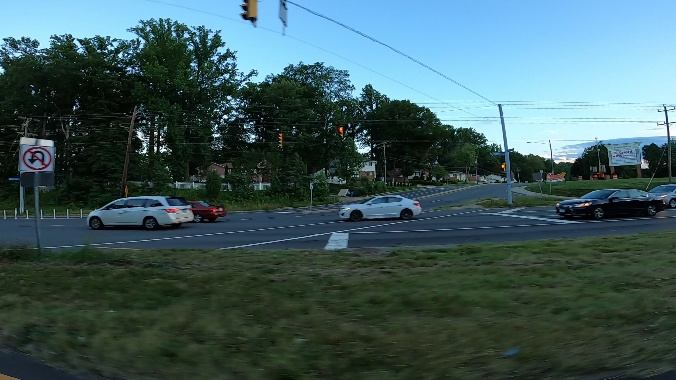

In [9]:
image = random.choice(index)
Image(filename=f'data/training_images/{image}.jpg',width=600)

## Training (Work in Progress)

In [10]:
source = 'training_images'

fold_list = [0]

for fold in fold_list:
    val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
    for name,mini in tqdm(df.groupby('image_id')):
        if name in val_index:
            path2save = 'val2017/'
        else:
            path2save = 'train2017/'
        if not os.path.exists('data/fold{}/labels/'.format(fold)+path2save):
            os.makedirs('data/fold{}/labels/'.format(fold)+path2save)
        with open('data/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
            row = mini[['classes','x_center','y_center','w','h']].astype(float).values
            row = row.astype(str)
            for j in range(len(row)):
                text = ' '.join(row[j])
                f.write(text)
                f.write("\n")
        if not os.path.exists('data/fold{}/images/{}'.format(fold,path2save)):
            os.makedirs('data/fold{}/images/{}'.format(fold,path2save))
        sh.copy("data/{}/{}.jpg".format(source,name),'data/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

In [11]:
%%writefile dataset.yaml
# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../data/fold0/  # dataset root dir
train: images/train2017 # train images (relative to 'path') 128 images
val: images/val2017  # val images (relative to 'path') 128 images
test:  # test images (optional)

# Classes (80 COCO classes)
names:
  0: car

Overwriting dataset.yaml


In [15]:
!pip install -U torch torchvision

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/0d/4a/e51420d46cfc90562e85af2fee912237c662ab31140ab179e49bd69401d6/torch-2.5.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/69/55/ce836703ff77bb21582c3098d5311f8ddde7eadc7eab04be9561961f4725/torchvision-0.20.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/26/9f/ad63fc0248c5379346306f8668cda6e2e2e9c95e01216d2b8ffd9ff037d0/typing_extensions-4.12.2-py3-none-any.whl.metadata
  Obtaining dependency information for sympy==1.13.1 from https://files.pythonhosted.org/packages/b2/fe/81695a1aa331a842b582453b605175f419fe8540355886031328089d840a/sympy-1.13.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.4 requires scipy>=1.11.2, but you have scipy 1.10.1 which is incompatible.
kaggle-environments 1.16.4 requires transformers>=4.33.1, but you have transformers 2.1.1 which is incompatible.


In [18]:
!pip install backports.tarfile

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for backports.tarfile from https://files.pythonhosted.org/packages/b9/fa/123043af240e49752f1c4bd24da5053b6bd00cad78c2be53c0d1e8b975bc/backports.tarfile-1.2.0-py3-none-any.whl.metadata


In [20]:
!python yolov5/train.py --batch 1 --epochs 12 --data dataset.yaml --weights yolov5s.pt --name yolov5x_fold0_new

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=12, batch_size=1, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=yolov5\data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5\runs\train, name=yolov5x_fold0_new, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-389-ge62a31b6 Python-3.11.4 torch-2.5.1+cpu CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0

In [21]:
def count_objects_in_images(detect_path):
    """Подсчёт объектов в детекциях YOLOv5."""
    # Место для улучшения
    #object_counts = {'cars': 0, 'buses': 0, 'trucks': 0}
    object_counts = {'cars': 0}
    for dirpath, _, filenames in os.walk(detect_path):
        for filename in filenames:
            if filename.endswith(".txt"):  # Результаты YOLO в формате .txt
                file_path = os.path.join(dirpath, filename)
                with open(file_path, "r") as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id = int(line.split()[0])  # Первый элемент строки — ID класса
                        if class_id == 0:  # Класс "car"
                            object_counts['cars'] += 1
                        elif class_id == 1:  # Класс "bus"
                            object_counts['buses'] += 1
                        elif class_id == 2:  # Класс "truck"
                            object_counts['trucks'] += 1

    return object_counts

# Путь к папке с результатами детекции
detect_path = "yolov5/runs/detect/exp"
object_counts = count_objects_in_images(detect_path)
print(f"Подсчитанные объекты: {object_counts}")

Подсчитанные объекты: {'cars': 0}


## Stats

In [264]:
train_path = "yolov5/runs/train/yolov5x_fold0_new2"

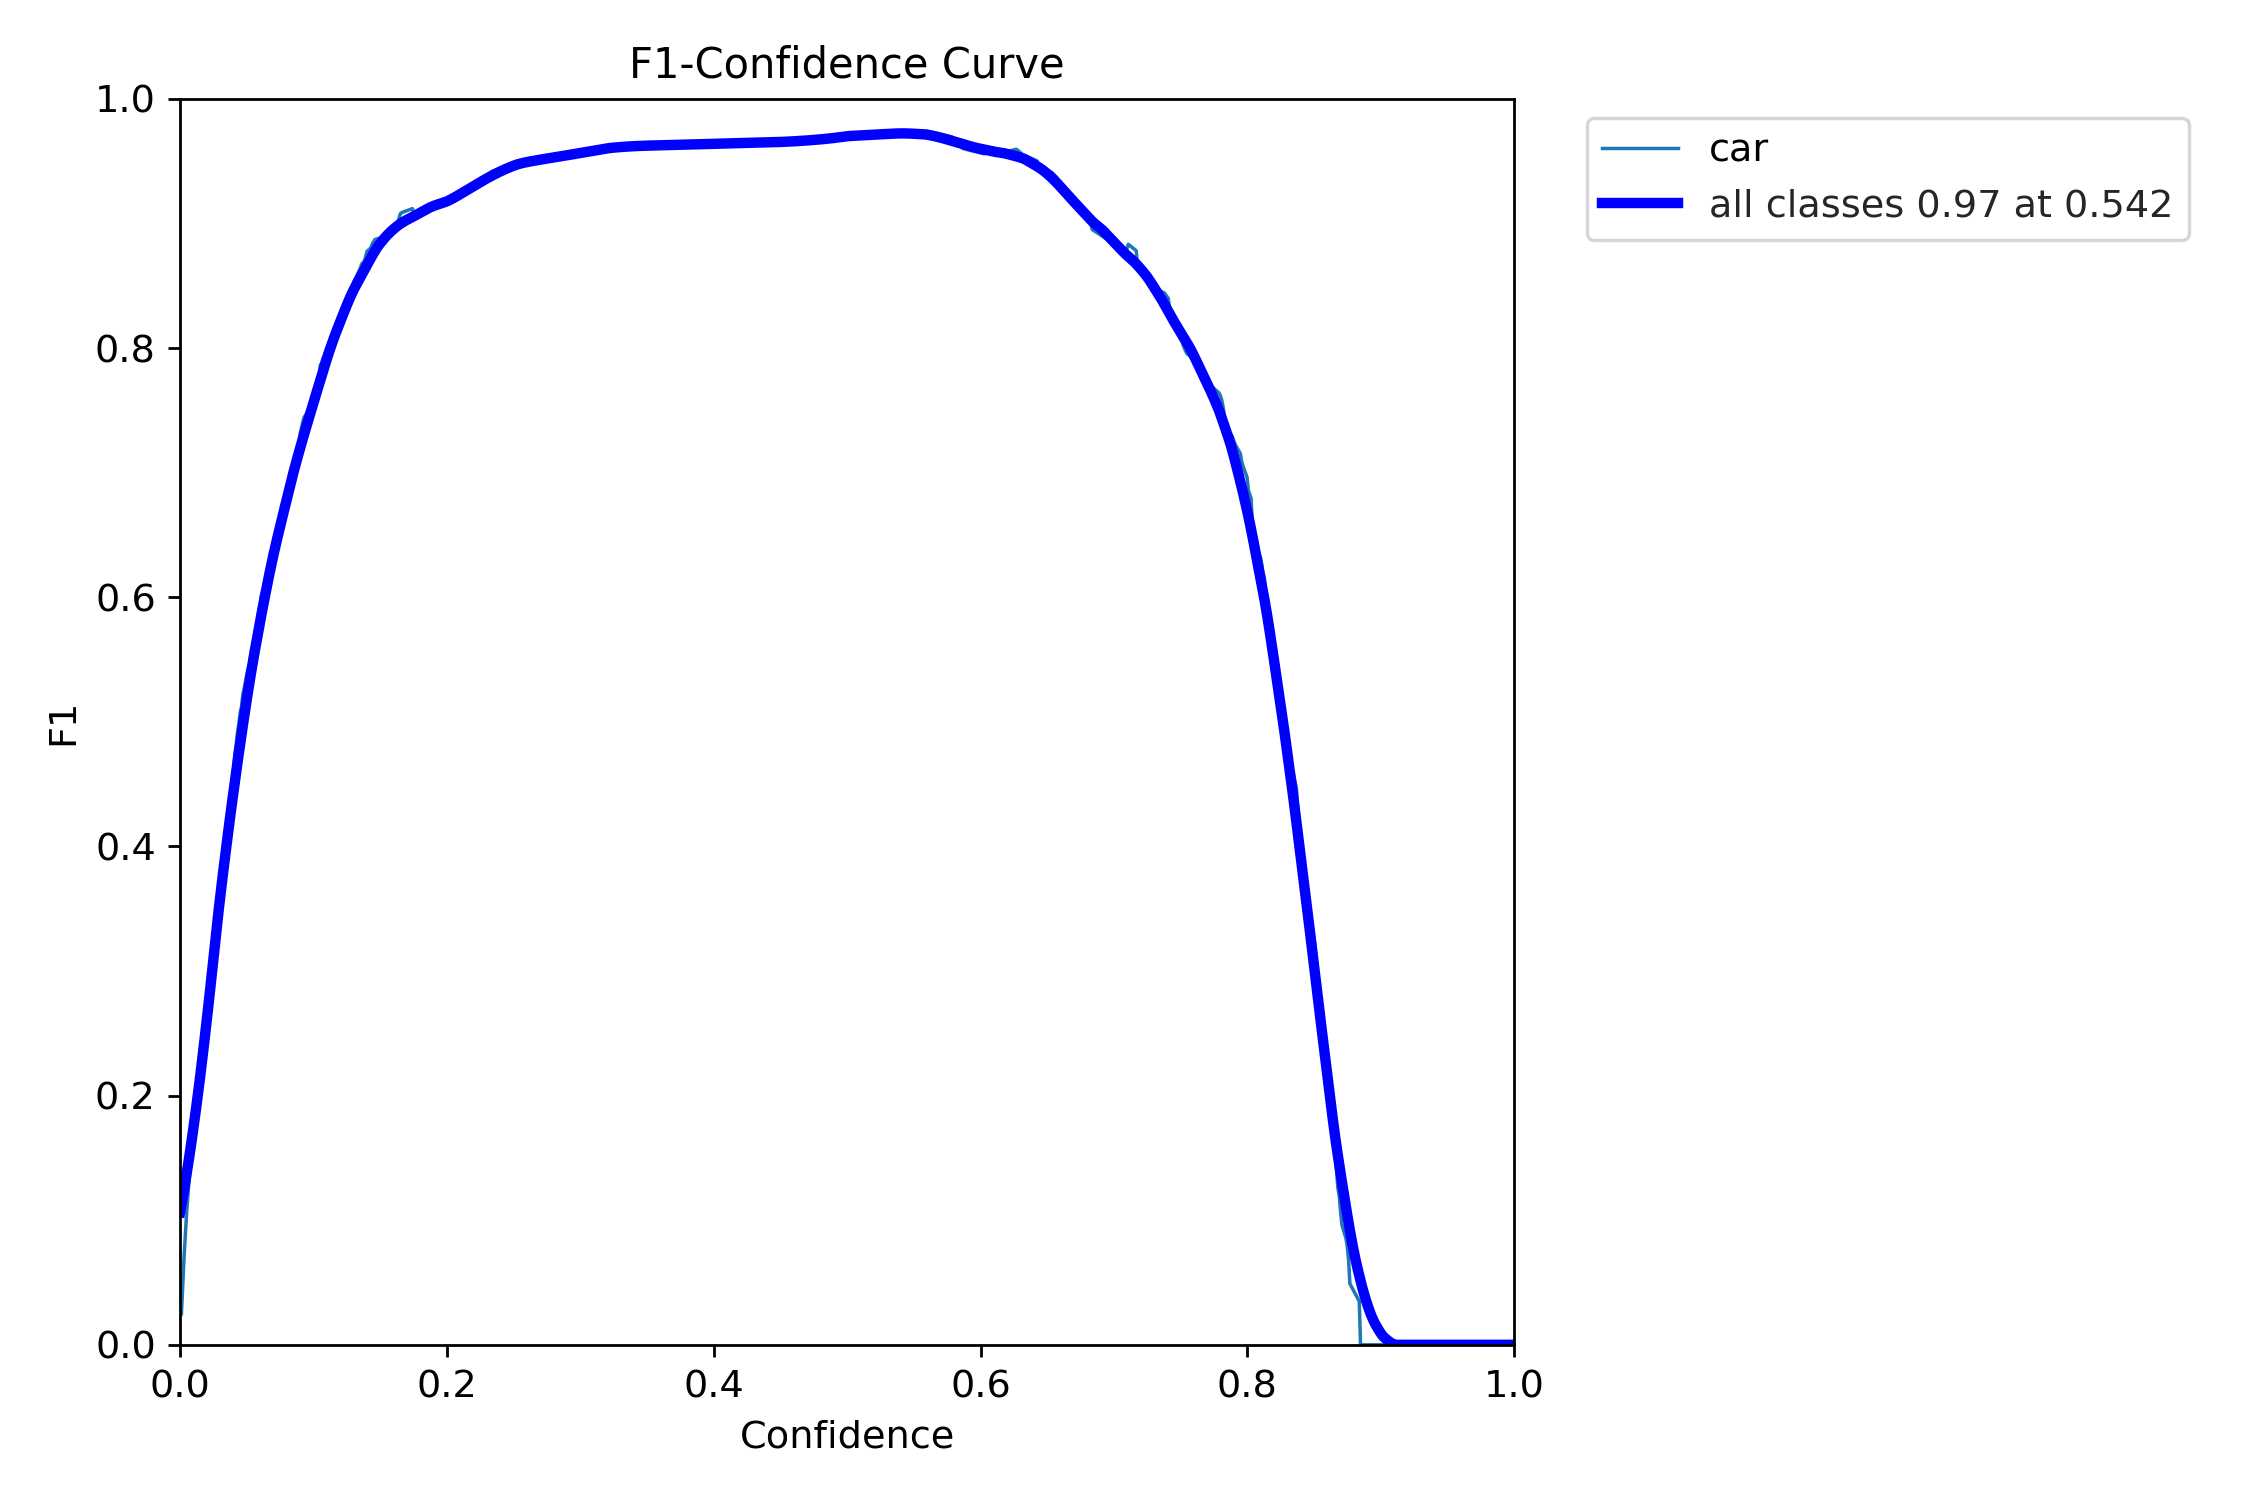

In [265]:
from PIL import Image
Image.open(f"{train_path}/F1_curve.png")

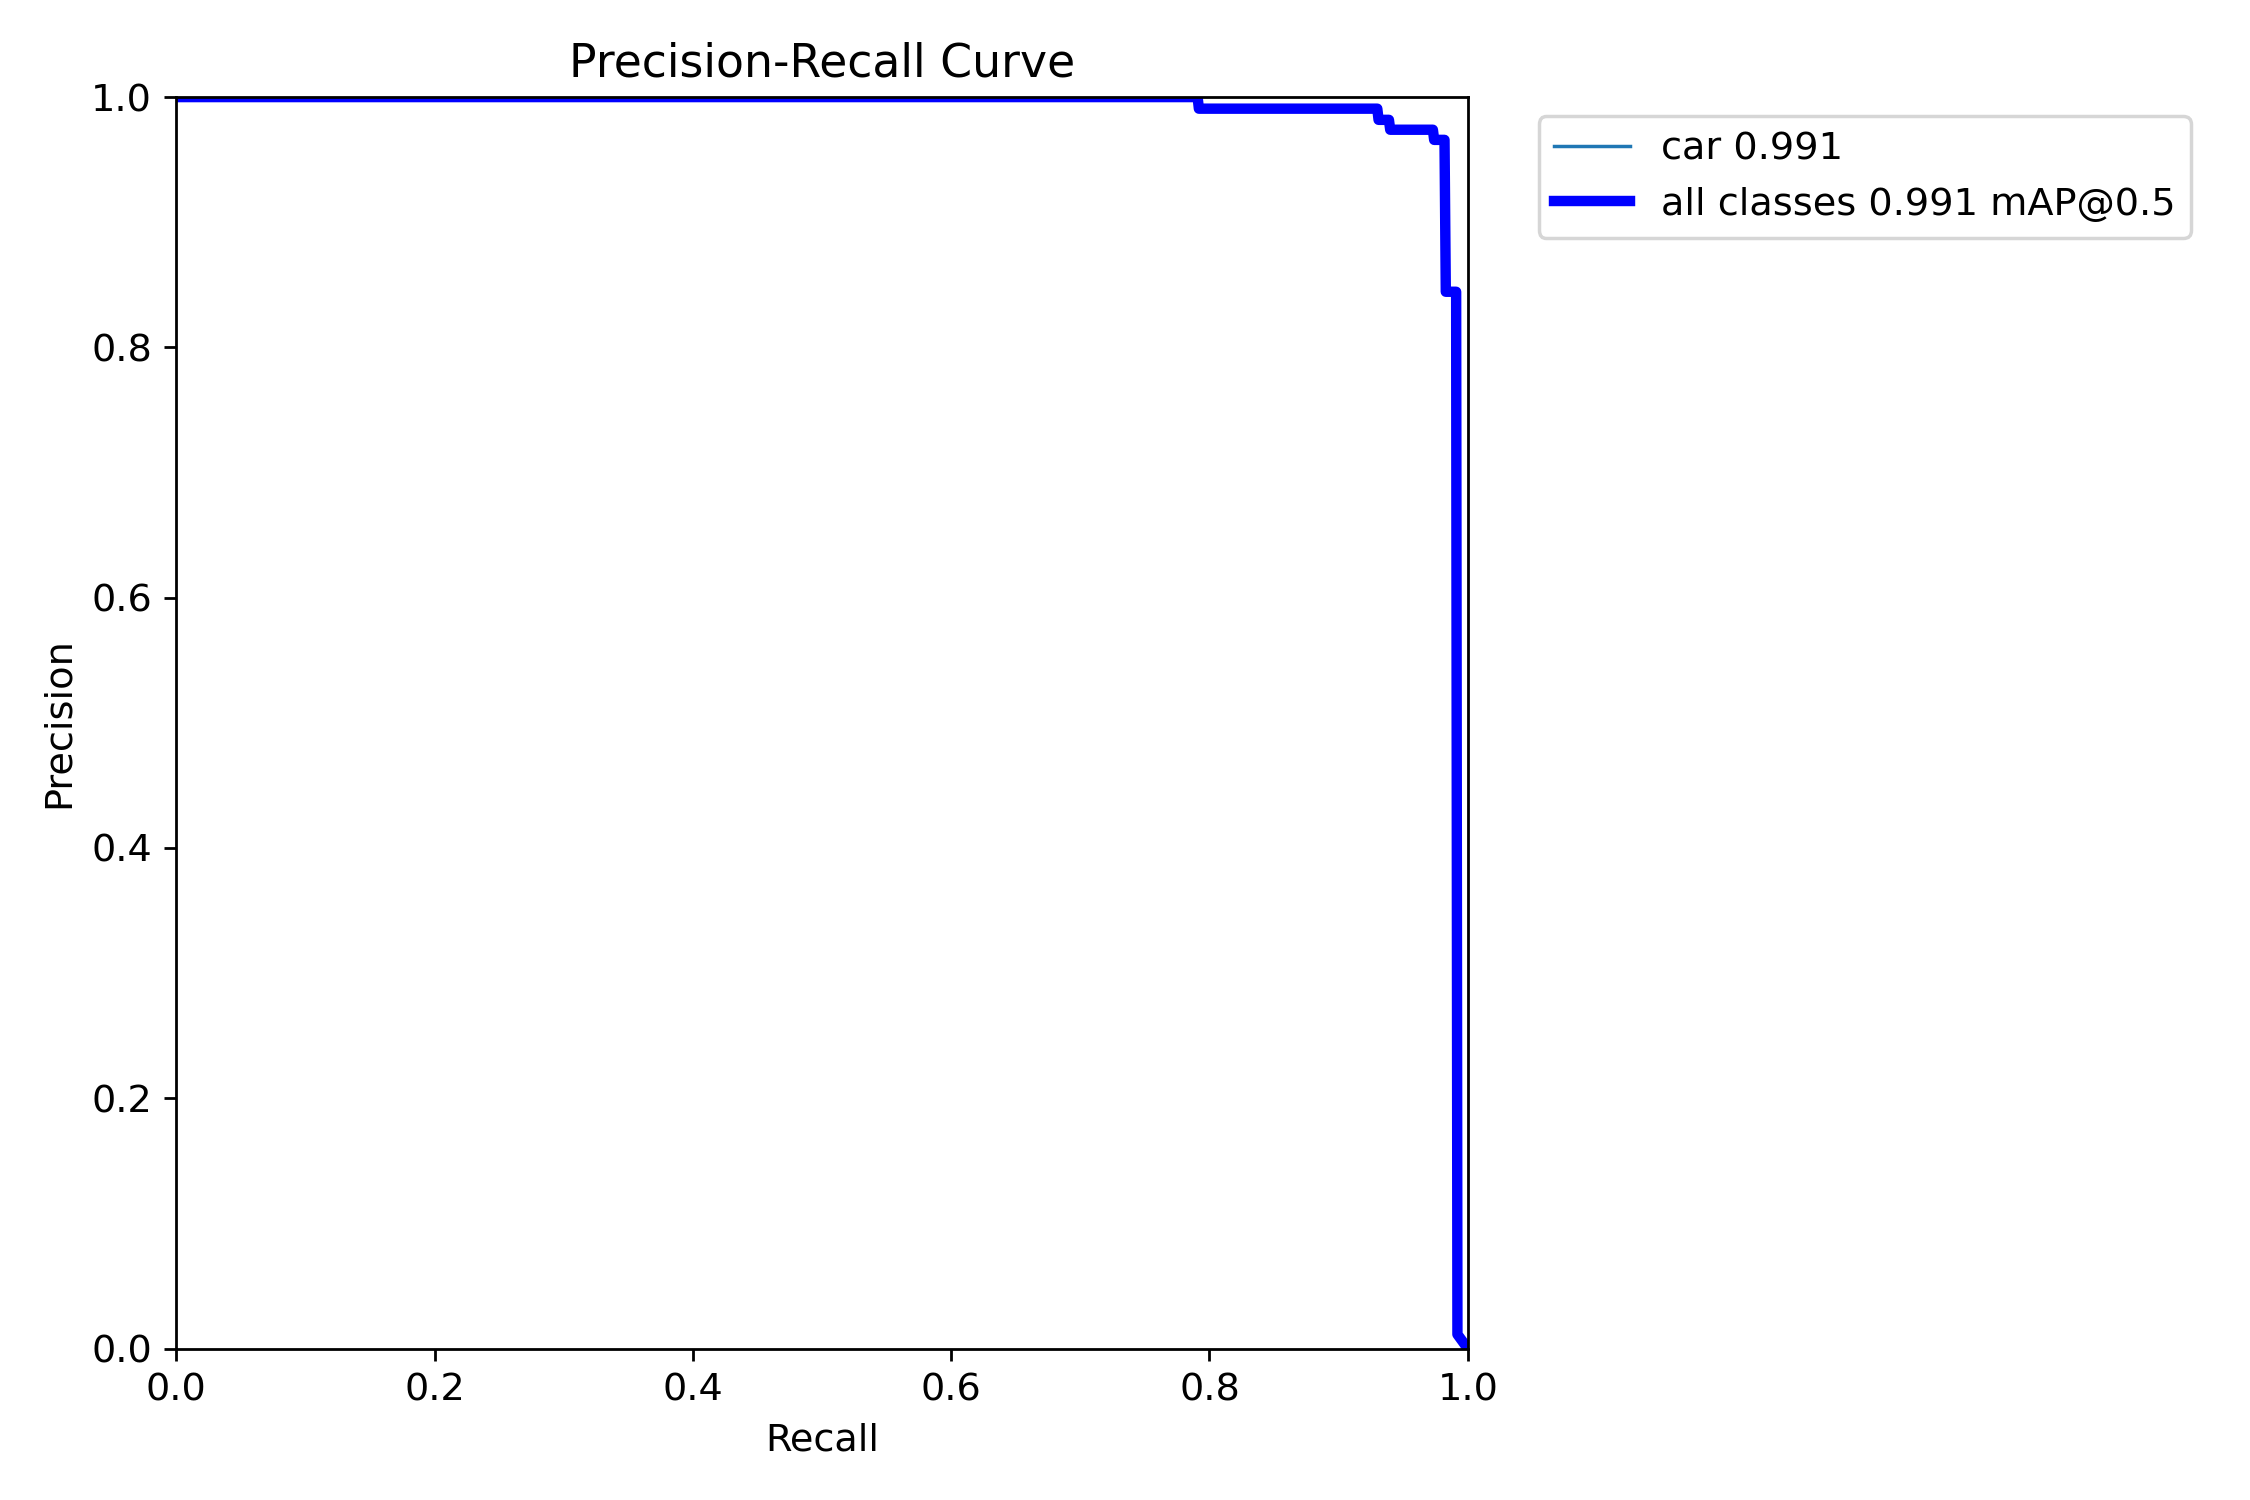

In [266]:
Image.open(f"{train_path}/PR_curve.png")

## Prediction

In [267]:
!python yolov5/detect.py --weights "{train_path}"/weights/best.pt --img 676 --conf 0.5 --source data/testing_images

detect: weights=['yolov5/runs/train/yolov5x_fold0_new2/weights/best.pt'], source=data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-389-ge62a31b6 Python-3.11.2 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce GTX 950, 1996MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /home/w15dev/ssd/src/python/hack/car_detect/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 18.1ms
image 2/175 /home/w15dev/ssd/src/python/hack/car_de

In [268]:
detect_path = "yolov5/runs/detect/exp"

In [269]:
predicted_files = [f"{dir}/{file}" for (dir, _, files) in os.walk(f"{detect_path}") for file in files]

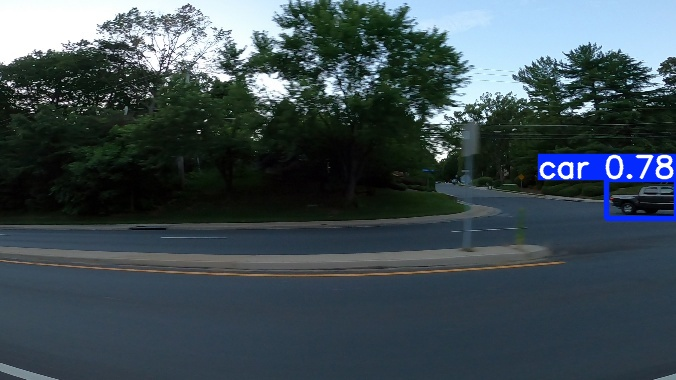

In [270]:
Image.open(f'{random.choice(predicted_files)}')

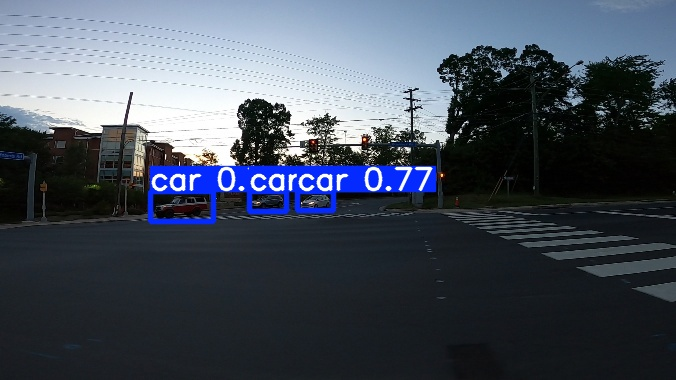

In [271]:
Image.open(f'{random.choice(predicted_files)}')

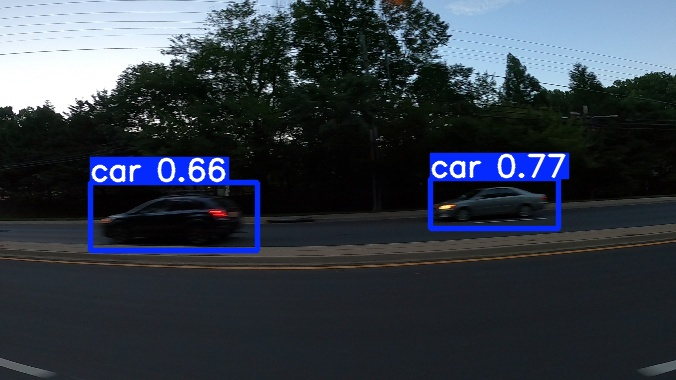

In [272]:
Image.open(f'{random.choice(predicted_files)}')

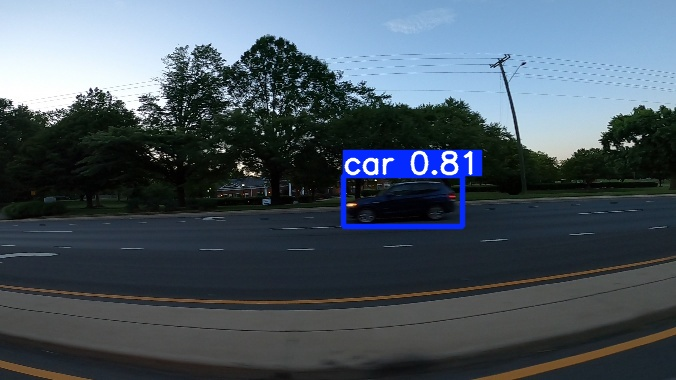

In [228]:
Image.open(f'{random.choice(predicted_files)}')

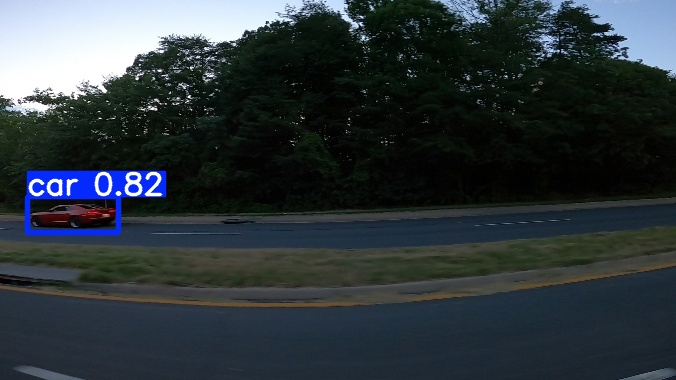

In [229]:
Image.open(f'{random.choice(predicted_files)}')

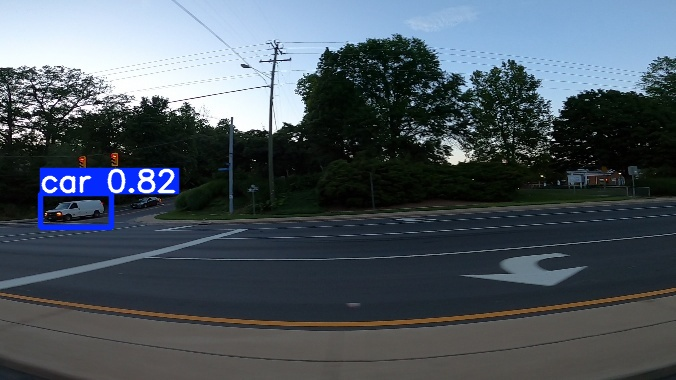

In [230]:
Image.open(f'{random.choice(predicted_files)}')

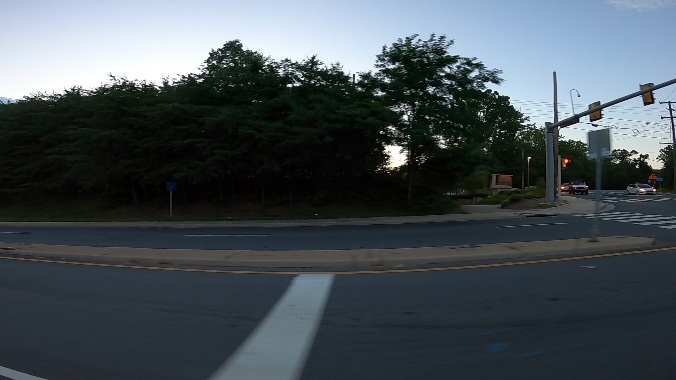

In [231]:
Image.open(f'{random.choice(predicted_files)}')

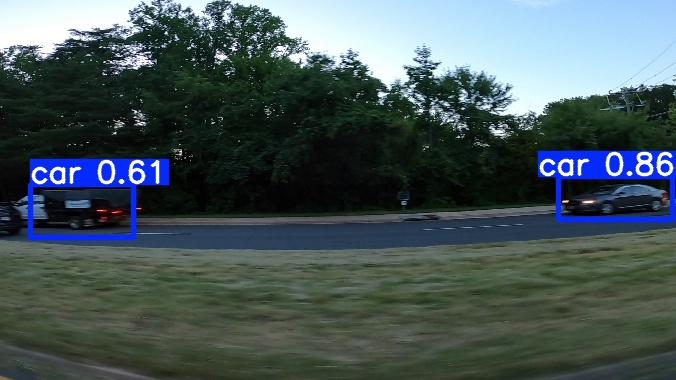

In [234]:
Image.open(f'{random.choice(predicted_files)}')

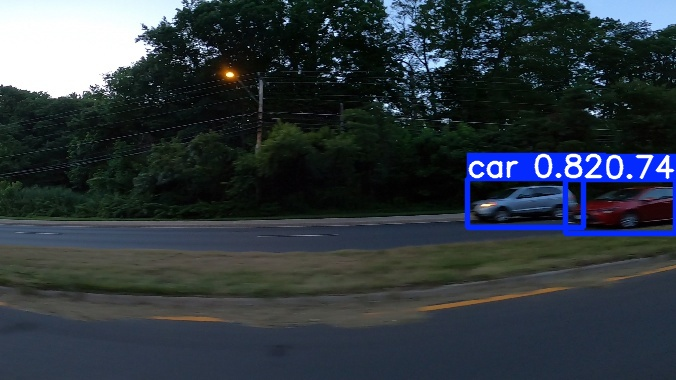

In [236]:
Image.open(f'{random.choice(predicted_files)}')

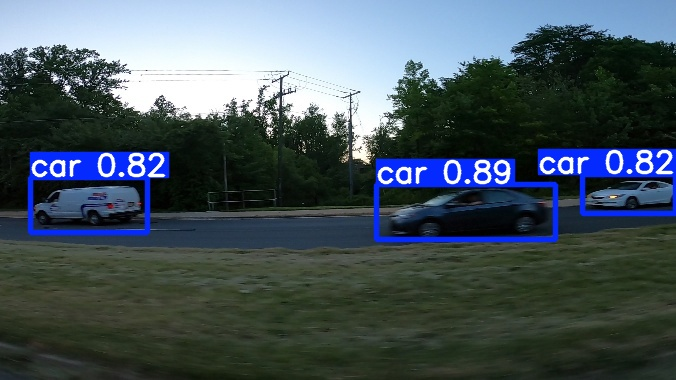

In [237]:
Image.open(f'{random.choice(predicted_files)}')